In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [7]:
print(arxiv.invoke("Latest research on Liquid Cooling"))

Published: 2007-09-12
Title: Liquid Cooling of Bright LEDs for Automotive Applications
Authors: Y. Lai, N. Cordero, F. Barthel, F. Tebbe, J. Kuhn, R. Apfelbeck, D. Würtenberger
Summary: With the advances in the technology of materials based on GaN, high
brightness white light emitting diodes (LEDs) have flourished over the past few
years and have shown to be very promising in many new illumination applications
such as outdoor illumination, task and decorative lighting as well as aircraft
and aut


In [8]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=5) 
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki,description="Query Wikipedia")
print(wiki.name)

wikipedia


In [10]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY") 
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")



In [11]:
from langchain_community.tools import TavilySearchResults
tavily = TavilySearchResults()

In [12]:
tavily.invoke("Latest research on Liquid Cooling")

[{'title': 'Experience the Latest in Liquid Cooling Technology by CoolIT ...',
  'url': 'https://www.hpcwire.com/2024/11/04/experience-the-latest-in-liquid-cooling-technology-by-coolit-systems-at-sc24/',
  'content': 'A survey conducted in Spring 2024 found that 38.3% of 812 IT professionals surveyed expect to use direct liquid cooling in their data center',
  'score': 0.6852132},
 {'title': 'Liquid Cooling - by Patrick Zhou - Deep Dive',
  'url': 'https://deepfundamental.substack.com/p/deep-dive-liquid-cooling',
  'content': 'Space saving: Liquid cooling allows for more compact server and rack configurations; according to a study by Schneider, liquid cooling helps save 10-14% of space vs. air cooling\n\nExtending equipment lifespan: Liquid cooling helps maintain more consistent temperature conditions for IT equipment, which improves hardware performance and longevity. A study from LiquidStack shows that liquid cooling extends the operational lifespan of equipment to 20-30 years from t

In [13]:
tools = [arxiv, wiki, tavily]

In [16]:
from langchain_groq import ChatGroq
model = ChatGroq(model="qwen-qwq-32b")

In [17]:
model.invoke("Latest research on Liquid Cooling")

AIMessage(content='\n<think>\nOkay, so I need to look into the latest research on liquid cooling. Let\'s see, where do I start? First, I remember that liquid cooling is a method used to dissipate heat more effectively than traditional air cooling. It\'s used in high-performance computing, data centers, and even some consumer electronics. But I need to focus on the latest research, so maybe I should think about recent advancements in materials, efficiency improvements, or new applications.\n\nWait, I should check if there are new studies on two-phase cooling. I think that\'s when the liquid evaporates to take heat away, right? Maybe they\'ve made progress there. Also, nanofluids – I\'ve heard about them before. They’re fluids with nanoparticles added to enhance thermal conductivity. Are there recent developments in that area?\n\nOh, and immersion cooling. I read that some data centers are using immersion cooling where components are submerged in dielectric fluids. Maybe there\'s been re

In [18]:
model_with_tools = model.bind_tools(tools=tools)

In [19]:
model_with_tools.invoke("What is the latest research on Liquid Cooling?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vpgy', 'function': {'arguments': '{"query": "Liquid Cooling"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 323, 'total_tokens': 477, 'completion_time': 0.378652918, 'prompt_time': 0.054972231, 'queue_time': 0.24670941799999999, 'total_time': 0.433625149}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a56caea0-3add-4746-9595-78f13638a177-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Liquid Cooling'}, 'id': 'call_vpgy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 323, 'output_tokens': 154, 'total_tokens': 477})

In [20]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [21]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 

In [24]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


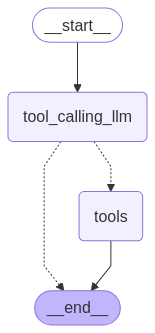

In [26]:
def tool_calling_llm(state:State):
    return {"messages":[model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

